# Прогнозирование цен на Airbnb
Данный проект направлен на прогнозирование стоимости одной ночи проживания. Итоговую модель можно использовать как для разместителей объявлений, чтобы назначить наиболее конкурентную стоимость ночи и увеличить среднюю загрузку за период, так и для туристов, чтобы выбрать наиболее привлекательное для них предложение.
Целевой метрикой будет метрика $R^2$, необходимо получить значение метрики не менее 0,7

# Загрузка данных и импорт необходимых библиотек

In [316]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from hyperopt import hp, fmin, tpe, Trials
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline



In [317]:
# загружаем данные
airnbnb_data = pd.read_csv('data/train.csv')
data = airnbnb_data.copy()
data.head()

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
0,1234376912864523021,Spacious Garden Apt in Center Square,Nestled in the vibrant heart of the historic C...,NaN,564967431,Stephanie,2024-03-02,NaN,NaN,within an hour,...,2024-10-28,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.44,Albany
1,887167811237271928,The Comfort II,Your family will be close to everything when y...,NaN,459472925,Gabriel,2022-05-16,"Albany, NY",NaN,within a few hours,...,2025-02-17,4.73,4.69,4.69,4.92,5.00,4.12,4.65,1.23,Albany
2,938271786418327576,Knickerbocker 3 The Argus Hotel,Large queen room with queen pull out couch loc...,The Argus Hotel is located directly on Washing...,526358730,Argus,2023-07-17,NaN,NaN,within an hour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Albany
3,898743867240851780,"Airy 5Br-2Ba,Kids Rm, 6TVs,Pvt Fence-yard&Park...","Whatever brings you to Albany, New York – wish...",NaN,516414095,Rashawn,2023-05-24,"Albany, NY",NaN,within an hour,...,2025-01-26,4.88,4.88,4.86,4.94,4.98,4.80,4.92,2.36,Albany
4,1005978346817864540,Massive 4BD/3BA 2-Fl Townhouse Apt Downtown Al...,Stay in our 4-bedroom townhouse-style 2-story ...,+ 92 Walkscore<br />+ 5-minute walk to MVP Are...,44434571,Earl,2015-09-17,NaN,"I grew up in Cebu, Philippines and moved to Ne...",within an hour,...,2025-01-26,4.80,4.86,4.84,4.86,4.90,4.61,4.76,2.99,Albany


In [318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261894 entries, 0 to 261893
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           261894 non-null  int64  
 1   name                         261894 non-null  object 
 2   description                  255801 non-null  object 
 3   neighborhood_overview        127687 non-null  object 
 4   host_id                      261894 non-null  int64  
 5   host_name                    261780 non-null  object 
 6   host_since                   261771 non-null  object 
 7   host_location                195064 non-null  object 
 8   host_about                   135708 non-null  object 
 9   host_response_time           221647 non-null  object 
 10  host_response_rate           221647 non-null  object 
 11  host_acceptance_rate         239348 non-null  object 
 12  host_is_superhost            254521 non-null  object 
 13 

Сразу удалим столбец id, так как все значения в нем уникальные и проверим количество полных дубликатов в данных и удали их


In [319]:
data.drop(['id'], axis=1, inplace=True)
print(f'Количество полных дубликатов в данных: {data.duplicated().sum()}')

Количество полных дубликатов в данных: 37


In [320]:
data.drop_duplicates(inplace=True)

# Предобработка данных и разведывательный анализ

Подробнее рассмотрим целевой признак

In [321]:
data['price'].describe()

count    261857.000000
mean        207.064172
std         197.296222
min           0.000000
25%          81.000000
50%         136.000000
75%         249.000000
max        1000.000000
Name: price, dtype: float64

Можно выделить потенциальные выбросы, такие как объекты с нулевой стоимостью

In [322]:
data = data[data['price'] > 0]

Удалив очевидные выбросы, посмотрим на распределение целевой переменной

<Axes: xlabel='price', ylabel='Count'>

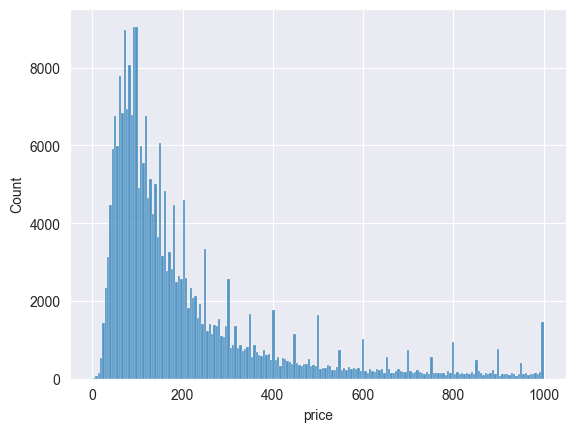

In [323]:
sns.histplot(data=data, x='price')

распределение напоминает логнормальное

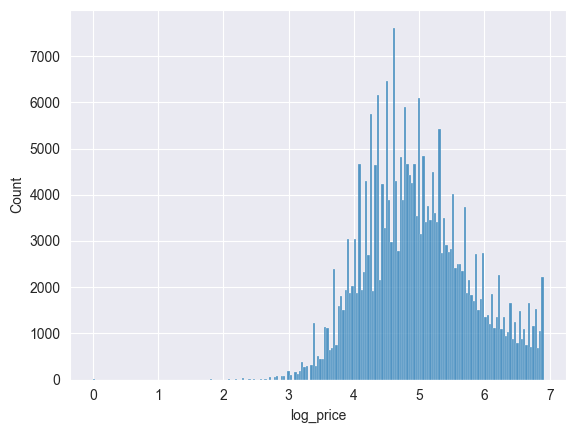

In [324]:
data['log_price'] = np.log(data['price'])
sns.histplot(data['log_price']);

Проверим нормальность распределения с помощью статистических тестов

In [325]:
# Anderson-Darling test
result = stats.anderson(data['log_price'], dist='norm')
print(f'AD statistic: {result.statistic:.3f}')
print('Critical values:', result.critical_values)

# D'Agostino's K² test
k2, p = stats.normaltest(data['log_price'])
print(f'K² statistic: {k2:.3f}, p-value = {p:.3e}')

AD statistic: 958.656
Critical values: [0.576 0.656 0.787 0.918 1.092]
K² statistic: 5565.170, p-value = 0.000e+00


In [326]:
print(f'Асимметрия: {stats.skew(data['log_price']):.3f}')
print(f'Эксцесс: {stats.kurtosis(data['log_price'], fisher=False):.3f}')
print(f'Среднее: {np.mean(data['log_price']):.3f} vs Median: {np.median(data['log_price']):.3f}')

Асимметрия: 0.302
Эксцесс: 2.668
Среднее: 4.987 vs Median: 4.913


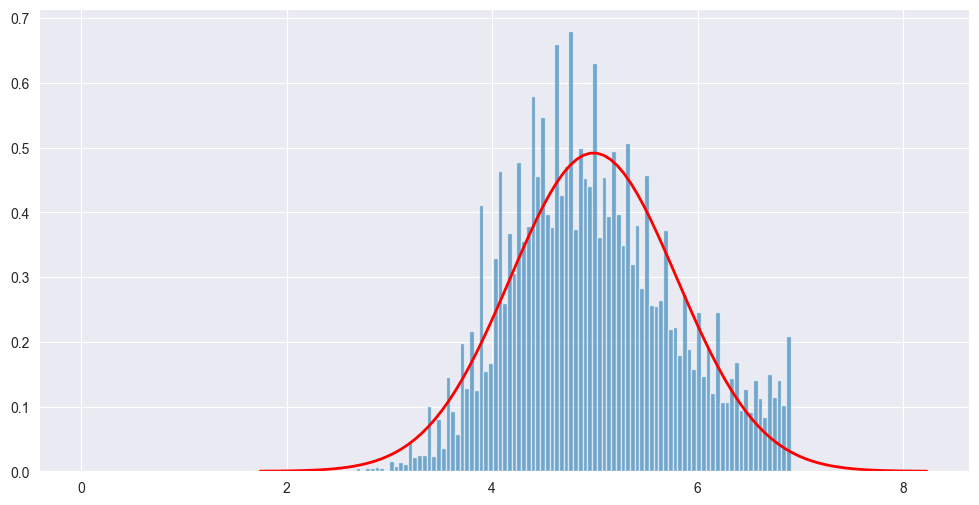

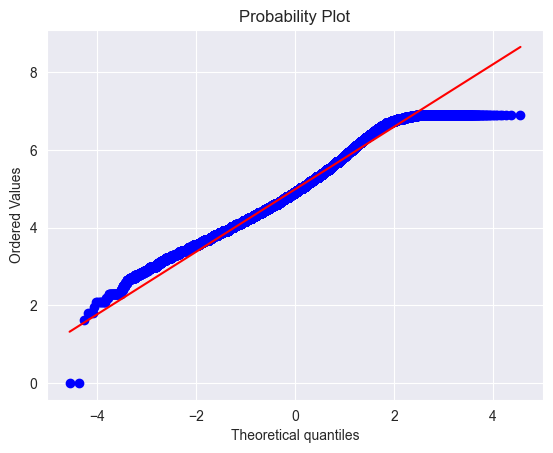

In [327]:
plt.figure(figsize=(12, 6))
plt.hist(data['log_price'], bins=150, density=True, alpha=0.6)
mu, std = np.mean(data['log_price']), np.std(data['log_price'])
x = np.linspace(mu - 4*std, mu + 4*std, 100)
plt.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2)
plt.show()

stats.probplot(data['log_price'], plot=plt)
plt.show()

После визуальных и статистических тестов нельзя однозначно что исходное распределение логнормальное, вероятнее всего это смесь нескольких распределений

In [328]:
data.nunique() / len(data) * 100

name                           97.717830
description                    89.616049
neighborhood_overview          42.453104
host_id                        66.296361
host_name                      17.025388
host_since                      2.151946
host_location                   3.891070
host_about                     28.826149
host_response_time              0.001528
host_response_rate              0.038189
host_acceptance_rate            0.038571
host_is_superhost               0.000764
host_neighbourhood              3.150968
host_listings_count             0.281452
host_total_listings_count       0.341791
host_verifications              0.003437
host_has_profile_pic            0.000764
host_identity_verified          0.000764
neighbourhood                   2.858823
neighbourhood_cleansed          2.061438
latitude                       89.382332
longitude                      91.314310
property_type                   0.053846
room_type                       0.001528
accommodates    

Удалим неинформативные признаки и признаки с большим количеством уникальных значений

In [329]:
data.drop(['name', 'log_price', 'description', 'host_id', 'host_name', 'host_about', 'host_location', 'neighbourhood_cleansed', 'host_verifications', 'first_review', 'last_review' ], axis=1, inplace=True)

Выделим и удалим признаки в которых более 50% пропусков

In [330]:
for feature in data.columns:
    if (data[feature].isna().sum() / len(data) * 100) > 40:
        data.drop(feature, axis=1, inplace=True)
data.isna().sum() / len(data) * 100

host_since                      0.046972
host_response_time             15.368370
host_response_rate             15.368370
host_acceptance_rate            8.608930
host_is_superhost               2.815670
host_listings_count             0.046972
host_total_listings_count       0.046972
host_has_profile_pic            0.046972
host_identity_verified          0.046972
latitude                        0.000000
longitude                       0.000000
property_type                   0.000000
room_type                       0.000000
accommodates                    0.000000
bathrooms                       0.047736
bathrooms_text                  0.089362
bedrooms                        0.133279
beds                            0.187126
amenities                       0.000000
price                           0.000000
has_availability                0.872999
availability_30                 0.000000
availability_60                 0.000000
availability_90                 0.000000
availability_365

Разделим удобства на категории и разобьем на отдельные признаки

In [331]:
basic_amenities = ['essentials', 'hot water', 'heating', 'air conditioning', 'wifi', 'dedicated workspace', 'hangers',
                   'bed linens', 'iron', 'clothing storage']

kitchen_amenities = ['kitchen', 'refrigerator', 'microwave', 'oven', 'stove', 'cooking basics', 'dishes and silverware',
                     'wine glasses', 'coffee maker', 'toaster', 'hot water kettle', 'blender', 'rice maker']

safety_amenities = ['smoke alarm', 'carbon monoxide alarm', 'fire extinguisher', 'first aid kit',
                    'exterior security cameras', 'safe', 'lock on bedroom door']

bathroom_amenities = ['hair dryer', 'shampoo', 'conditioner', 'shower gel', 'body soap', 'bathtub', 'bidet']

entertainment_amenities = ['tv', 'netflix', 'hulu', 'amazon prime video', 'sound system', 'board games',
                           'books and reading material']

laundry_amenities = ['washer', 'dryer', 'drying rack for clothing', 'laundromat nearby']

parking_amenities = ['free parking on premises', 'free street parking', 'paid parking']

kids_amenities = ["crib", "high chair", "children's dinnerware", "children's books and toys", 'baby bath']

accessibility_amenities = ['elevator', 'single level home', 'step-free access']

outdoor_amenities = ['outdoor furniture', 'bbq grill', 'garden, patio or balcony', 'outdoor dining area']

special_amenities = ['pool', 'hot tub', 'gym', 'sauna', 'indoor fireplace', 'beach access']
basic_data = []
kitchen_data = []
safety_data = []
parking_data = []
accessibility_data = []
outdoor_data = []
special_data = []
kids_data = []
laundry_data = []
entertainment_data = []
bathroom_data = []
other_data = []
for i in range(len(data)):
    words = data['amenities'].iloc[i].replace('[', '').replace(']', '').replace('"', '').split(', ')
    basic_counter = 0
    kitchen_counter = 0
    safety_counter = 0
    parking_counter = 0
    accessibility_counter = 0
    outdoor_counter = 0
    special_counter = 0
    kids_counter = 0
    laundry_counter = 0
    entertainment_counter = 0
    bathroom_counter = 0
    other_counter = 0
    for word in words:
        if word.lower() in basic_amenities:
            basic_counter += 1
        if word.lower() in kitchen_amenities:
            kitchen_counter += 1
        if word.lower() in safety_amenities:
            safety_counter += 1
        if word.lower() in parking_amenities:
            parking_counter += 1
        if word.lower() in accessibility_amenities:
            accessibility_counter += 1
        if word.lower() in outdoor_amenities:
            outdoor_counter += 1
        if word.lower() in special_amenities:
            special_counter += 1
        if word.lower() in kids_amenities:
            kids_counter += 1
        if word.lower() in laundry_amenities:
            laundry_counter += 1
        if word.lower() in entertainment_amenities:
            entertainment_counter += 1
        if word.lower() in bathroom_amenities:
            bathroom_counter += 1
        else:
            other_counter += 1
    basic_data.append(basic_counter)
    kitchen_data.append(kitchen_counter)
    safety_data.append(safety_counter)
    parking_data.append(parking_counter)
    accessibility_data.append(accessibility_counter)
    outdoor_data.append(outdoor_counter)
    special_data.append(special_counter)
    kids_data.append(kids_counter)
    laundry_data.append(laundry_counter)
    entertainment_data.append(entertainment_counter)
    bathroom_data.append(bathroom_counter)
    other_data.append(other_counter)

data['basic_amenities'] = basic_data
data['kitchen_amenities'] = kitchen_data
data['safety_amenities'] = safety_data
data['parking_amenities'] = parking_data
data['accessibility_amenities'] = accessibility_data
data['outdoor_amenities'] = outdoor_data
data['kids_amenities'] = kids_data
data['laundry_amenities'] = laundry_data
data['entertainment_amenities'] = entertainment_data
data['bathroom_amenities'] = bathroom_data
data['other_amenities'] = other_data
data['special_amenities'] = special_data
data.drop(['amenities'], axis=1, inplace=True)

Переведем и закодируем время ответа хоста

In [332]:
data['host_response_time'] = data['host_response_time'].fillna('no data')
dummies = pd.get_dummies(data['host_response_time'])
data = pd.concat([data, dummies], axis=1)
data.drop(['host_response_time'], axis=1, inplace=True)


Переведем дату появление хоста на airbnb в категориальный признак срока его использования сайта

In [333]:
data['host_since'] = pd.to_datetime(data['host_since'])
data['host_since_diff'] = 2025 - data['host_since'].dt.year
data.drop(['host_since'], axis=1, inplace=True)
host_duration = []
for i in range(len(data)):
    if data['host_since_diff'].iloc[i] < 4:
        host_duration.append('less than 4 years')
    elif data['host_since_diff'].iloc[i] < 8:
        host_duration.append('4 to 8 years')
    elif data['host_since_diff'].iloc[i] < 12:
        host_duration.append('8 to 12 years')
    else:
        host_duration.append('more than 12 years')
data['host_duration'] = host_duration
dummies = pd.get_dummies(data['host_duration'], prefix='host_duration')
data = pd.concat([data, dummies], axis=1)
data.drop(['host_duration', 'host_since_diff'], axis=1, inplace=True)

Переведем все признаки с условными обозначениями в булевый формат

In [334]:
data['host_is_superhost'] = data['host_is_superhost'].apply(lambda x: True if x == 't' else False)
data['host_has_profile_pic'] = data['host_has_profile_pic'].apply(lambda x: True if x == 't' else False)
data['host_identity_verified'] = data['host_identity_verified'].apply(lambda x: True if x == 't' else False)
data['has_availability'] = data['has_availability'].apply(lambda x: True if x == 't' else False)

Переведем в категориальный формат и закодируем процент ответов и одобрений хоста

In [335]:
host_response = []
data['host_response_rate'] = data['host_response_rate'].fillna('109%')
for i in range(len(data)):
    if int((data['host_response_rate'].iloc[i]).replace('%', '')) < 25:
        host_response.append('less than 25%')
    elif int((data['host_response_rate'].iloc[i]).replace('%', '')) < 50:
        host_response.append('25% to 50%')
    elif int((data['host_response_rate'].iloc[i]).replace('%', '')) < 75:
        host_response.append('50% to 75%')
    elif int((data['host_response_rate'].iloc[i]).replace('%', '')) < 90:
        host_response.append('75% to 90%')
    elif int((data['host_response_rate'].iloc[i]).replace('%', '')) < 100:
        host_response.append('90% to 100%')
    else:
        host_response.append('no data')
data['host_response_rate'] = host_response

dummies = pd.get_dummies(data['host_response_rate'], prefix='host_response_rate')
data = pd.concat([data, dummies], axis=1)
data.drop(['host_response_rate'], axis=1, inplace=True)

In [336]:
host_acceptance = []
data['host_acceptance_rate'] = data['host_acceptance_rate'].fillna('109%')
for i in range(len(data)):
    if int((data['host_acceptance_rate'].iloc[i]).replace('%', '')) < 25:
        host_acceptance.append('less than 25%')
    elif int((data['host_acceptance_rate'].iloc[i]).replace('%', '')) < 50:
        host_acceptance.append('25% to 50%')
    elif int((data['host_acceptance_rate'].iloc[i]).replace('%', '')) < 75:
        host_acceptance.append('50% to 75%')
    elif int((data['host_acceptance_rate'].iloc[i]).replace('%', '')) < 90:
        host_acceptance.append('75% to 90%')
    elif int((data['host_acceptance_rate'].iloc[i]).replace('%', '')) < 100:
        host_acceptance.append('90% to 100%')
    else:
        host_acceptance.append('no data')
data['host_acceptance_rate'] = host_acceptance
dummies = pd.get_dummies(data['host_acceptance_rate'], prefix='host_acceptance')
data = pd.concat([data, dummies], axis=1)
data.drop(['host_acceptance_rate'], axis=1, inplace=True)

Закодируем тип комнат



In [337]:
dumies = pd.get_dummies(data['room_type'], prefix='room_type')
data = pd.concat([data, dumies], axis=1)
data.drop(['room_type'], axis=1, inplace=True)

Выделим 4 наиболее встречающихся типов зданий, все остальные отнесем к "other", после чего закодируем признак

In [338]:
top_property = data['property_type'].value_counts(normalize=True).nlargest(4).index
data['property_type'] = data['property_type'].apply(lambda x: x if x in top_property else 'other')
dummies = pd.get_dummies(data['property_type'], prefix='property_type')
data = pd.concat([data, dummies], axis=1)
data.drop(['property_type'], axis=1, inplace=True)

Закодируем города количеством их вхождений в данные

In [339]:
data['city_encoded'] = data['city'].map(data['city'].value_counts())
data.drop(['city'], axis=1, inplace=True)

 Обработаем текстовый признак ванн, выделив их количество и необходимость их делить

In [340]:
def extract_bath_features(text):
    if pd.isna(text):
        return np.nan, np.nan

    # Разбиваем строку на части
    parts = text.split()

    # Извлекаем количество ванн (если есть число)
    bath_count = None
    for part in parts:
        # Пытаемся извлечь число (целое или дробное)
        cleaned_part = ''.join([c for c in part if c.isdigit() or c == '.'])
        if cleaned_part:
            try:
                bath_count = float(cleaned_part)
                break
            except ValueError:
                continue

    # Если число не найдено (например, "Shared half-bath"), считаем 1 или 0.5 для half-bath
    if bath_count is None:
        if 'half' in text.lower():
            bath_count = 0.5
        else:
            bath_count = 1.0  # или 0.0, если "no bath"

    # Определяем тип ванной (private/shared/half/standard)
    bath_type = (
        'private' if 'private' in text.lower() else
        'shared' if 'shared' in text.lower() else
        'half' if 'half' in text.lower() else
        'standard'
    )

    return bath_count, bath_type

# Применяем функцию
data[['bath_count', 'bath_type']] = data['bathrooms_text'].apply(
    lambda x: pd.Series(extract_bath_features(x))
)

# Заполняем пропуски (если были)
data['bath_count'] = data['bath_count'].fillna(0.0)  # или median()
data['bath_type'] = data['bath_type'].fillna('unknown')

# Дополнительные бинарные признаки
data['bath_is_shared'] = data['bathrooms_text'].str.contains('shared', case=False, na=False).astype(int)
data['bath_is_half'] = data['bathrooms_text'].str.contains('half', case=False, na=False).astype(int)
data.drop(['bathrooms_text'], axis=1, inplace=True)
dummies = pd.get_dummies(data['bath_type'], prefix='bath_type')
data = pd.concat([data, dummies], axis=1)
data.drop(['bath_type'], axis=1, inplace=True)
# удалим оставшиеся строки с пропусками
data = data.dropna()

# Обучение и настройка моделей

In [341]:
# разделим данные на отдельные признаки и целевой признак
X = data.drop(['price'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# сразу оставим лишь половину признаков, оставив только наиболее статистически важные
selector = SelectKBest(k=40).fit(X_train, y_train).get_feature_names_out()
X_train = X_train[selector]
X_test = X_test[selector]


Создадим baseline модель которая предсказывает медианное значение

In [342]:
baseline = DummyRegressor(strategy="median")
baseline.fit(X_train, y_train)
print("Baseline R^2:", metrics.r2_score(y_test, baseline.predict(X_test)))

Baseline R^2: -0.12911996130277914


Обучим дерево решений

In [343]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)


print(f'test score{metrics.r2_score(y_test, y_pred)}')
print(f'train score{metrics.r2_score(y_train, y_pred_train)}')

test score0.5586935801549494
train score0.5627522468135846


In [344]:
space={
       'max_depth' : hp.quniform('max_depth', 2, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 15, 1)
      }
def hyperopt_dt(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {
              'max_depth': int(params['max_depth']),
             'min_samples_leaf': int(params['min_samples_leaf'])
              }

    # используем эту комбинацию для построения модели
    model = DecisionTreeRegressor(**params, random_state=random_state)

    # обучаем модель




    # применим  cross validation с тем же количеством фолдов
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score


# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best_param = fmin(hyperopt_dt, # наша функция
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_param))

100%|██████████| 20/20 [00:41<00:00,  2.09s/trial, best loss: -0.6340689222963436]
Наилучшие значения гиперпараметров {'max_depth': np.float64(17.0), 'min_samples_leaf': np.float64(13.0)}


In [345]:
dt = DecisionTreeRegressor(max_depth=int(best_param['max_depth']), min_samples_leaf=int(best_param['min_samples_leaf']))
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)


print(f'test score{metrics.r2_score(y_test, y_pred)}')
print(f'train score{metrics.r2_score(y_train, y_pred_train)}')

test score0.6421606221187357
train score0.7605952858772009


Дерево решений неплохо справляется с предсказанием, но получение значение метрики не удовлетворяет заданному значению

Попробуем обучить случайный лес

In [346]:
rf = RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=4, n_estimators=85)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f'test score{metrics.r2_score(y_test, y_pred)}')
print(f'train score{metrics.r2_score(y_train, y_pred_train)}')

test score0.6657131722789615
train score0.6945873471055615


In [347]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 100, 1),
}
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
    model = RandomForestRegressor(**params, random_state=42)
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1).mean()
    return -score

trials = Trials() # используется для логирования результатов

best_param = fmin(hyperopt_rf, # наша функция
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(42)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_param))

100%|██████████| 10/10 [07:44<00:00, 46.47s/trial, best loss: -0.6515432326629129]
Наилучшие значения гиперпараметров {'max_depth': np.float64(9.0), 'min_samples_leaf': np.float64(10.0), 'n_estimators': np.float64(83.0)}


In [348]:
rf = RandomForestRegressor(random_state=42, max_depth=int(best_param['max_depth']), min_samples_leaf=int(best_param['min_samples_leaf']), n_estimators=int(best_param['n_estimators']))
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)
print(f'test score{metrics.r2_score(y_test, y_pred)}')
print(f'train score{metrics.r2_score(y_train, y_pred_train)}')

test score0.6519913665220711
train score0.6687363580936202


In [349]:
gb = GradientBoostingRegressor( #функция потерь
    learning_rate=0.2, #темп обучения
    n_estimators=1000, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел,
    min_samples_leaf=7
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
y_pred_train = gb.predict(X_train)

print(f'test score{metrics.r2_score(y_test, y_pred)}')
print(f'train score{metrics.r2_score(y_train, y_pred_train)}')

test score0.7241030015068832
train score0.7522296548482615


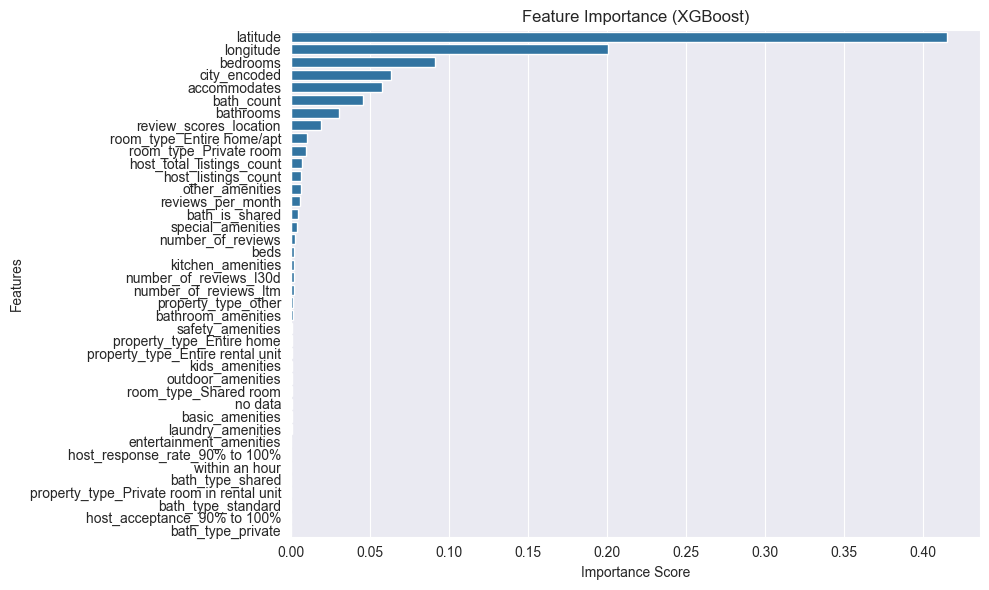

In [350]:
# Получение важности признаков
importance = gb.feature_importances_
feature_namess = X_train.columns
# Создание DataFrame для удобства
feature_importance = pd.DataFrame({
    'Feature': feature_namess,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, )
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

С помощью использования градиентного бустинга удалось достичь поставленной метрики, однако попробуем еще немного улучшить показатели модели с помощью настройки гиперпараметров

Создаем новый трансформер для того чтобы завернуть всю необходимую предобработку в пайплайн

# Подготовка к продакшену

In [354]:
class AirbnbFinalFeaturesPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Категории аментис
        self.amenity_categories = {
            'basic': ['essentials', 'hot water', 'heating', 'air conditioning', 'wifi',
                     'dedicated workspace', 'hangers', 'bed linens', 'iron', 'clothing storage'],
            'kitchen': ['kitchen', 'refrigerator', 'microwave', 'oven', 'stove',
                       'cooking basics', 'dishes and silverware', 'wine glasses',
                       'coffee maker', 'toaster', 'hot water kettle', 'blender', 'rice maker'],
            'safety': ['smoke alarm', 'carbon monoxide alarm', 'fire extinguisher',
                      'first aid kit', 'exterior security cameras', 'safe', 'lock on bedroom door'],
            'bathroom': ['hair dryer', 'shampoo', 'conditioner', 'shower gel',
                        'body soap', 'bathtub', 'bidet'],
            'outdoor': ['outdoor furniture', 'bbq grill', 'garden, patio or balcony',
                       'outdoor dining area'],
            'special': ['pool', 'hot tub', 'gym', 'sauna', 'indoor fireplace', 'beach access']
        }

        # Фиксированный список типов собственности
        self.property_types = [
            'Entire rental unit',
            'Entire home',
            'Private room in rental unit'
        ]

        # Фиксированный список фичей для сохранения
        self.final_features = [
            'host_listings_count', 'host_total_listings_count', 'latitude',
            'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
            'availability_30', 'availability_60', 'availability_90',
            'availability_365', 'number_of_reviews_l30d',
            'review_scores_rating', 'review_scores_location',
            'reviews_per_month', 'basic_amenities', 'kitchen_amenities',
            'safety_amenities', 'outdoor_amenities', 'bathroom_amenities',
            'other_amenities', 'special_amenities', 'no data',
            'within an hour', 'room_type_Entire home/apt',
            'room_type_Private room', 'property_type_Entire home',
            'property_type_Entire rental unit',
            'property_type_Private room in rental unit', 'city_encoded',
            'bath_count', 'bath_is_shared', 'bath_type_shared',
            'bath_type_standard'
        ]

        self.city_encoding = {'Albany': 19, 'Amsterdam': 390, 'Antwerp': 271, 'Asheville': 309, 'Athens': 1692, 'Austin': 1282, 'Bangkok': 279, 'Barcelona': 1761, 'Barossa Valley': 27, 'Barwon South West, Vic': 956, 'Belize': 315, 'Bergamo': 573, 'Berlin': 1022, 'Bologna': 616, 'Bordeaux': 712, 'Boston': 352, 'Bozeman': 55, 'Brisbane': 344, 'Bristol': 177, 'Broward County': 2546, 'Brussels': 528, 'Cambridge': 65, 'Cape Town': 269, 'Chicago': 754, 'Clark County, NV': 1787, 'Columbus': 238, 'Copenhagen': 225, 'Crete': 4159, 'Dallas': 543, 'Denver': 442, 'Dublin': 376, 'Edinburgh': 414, 'Euskadi': 973, 'Florence': 1539, 'Fort Worth': 167, 'Geneva': 182, 'Ghent': 93, 'Girona': 3667, 'Greater Manchester': 595, 'Hawaii': 5603, 'Hong Kong': 411, 'Ireland': 2615, 'Istanbul': 189, 'Jersey City': 200, 'Lisbon': 2786, 'London': 5159, 'Los Angeles': 3476, 'Lyon': 552, 'Madrid': 2280, 'Mallorca': 2556, 'Malta': 1625, 'Melbourne': 1609, 'Menorca': 676, 'Mexico City': 655, 'Mid North Coast': 705, 'Milan': 2051, 'Montreal': 842, 'Mornington Peninsula': 720, 'Munich': 416, 'Naples': 1369, 'Nashville': 1210, 'New Brunswick': 400, 'New Orleans': 861, 'New York City': 1822, 'Newark': 145, 'Northern Rivers': 665, 'Oakland': 186, 'Oslo': 144, 'Ottawa': 180, 'Pacific Grove': 34, 'Paris': 6976, 'Portland': 407, 'Porto': 1848, 'Prague': 143, 'Puglia': 6637, 'Quebec City': 233, 'Rhode Island': 579, 'Riga': 377, 'Rio de Janeiro': 3242, 'Rochester': 61, 'Rotterdam': 64, 'Salem, OR': 25, 'San Diego': 1524, 'San Francisco': 526, 'San Mateo County': 277, 'Santa Clara County': 414, 'Santa Cruz County': 256, 'Seattle': 659, 'Sicily': 8186, 'Singapore': 177, 'South Aegean': 4448, 'Sunshine Coast': 987, 'Sydney': 1457, 'Taipei': 39, 'Tasmania': 683, 'The Hague': 90, 'Thessaloniki': 587, 'Toronto': 1256, 'Twin Cities MSA': 532, 'Valencia': 986, 'Vancouver': 256, 'Vaud': 514, 'Venice': 994, 'Victoria': 375, 'Vienna': 1390, 'Washington, D.C': 533, 'Western Australia': 1347, 'Winnipeg': 58}

        # Для one-hot кодирования
        self.room_type_categories = ['Entire home/apt', 'Private room']
        self.response_time_categories = ['no data', 'within an hour']
        self.bath_type_categories = ['shared', 'standard']

    @staticmethod
    def extract_bath_features(text):
        if pd.isna(text):
            return np.nan, np.nan

        text = str(text).lower()  # Приводим к строке и нижнему регистру
        parts = text.split()
        bath_count = None

        for part in parts:
            cleaned_part = ''.join([c for c in part if c.isdigit() or c == '.'])
            if cleaned_part:
                try:
                    bath_count = float(cleaned_part)
                    break
                except ValueError:
                    continue

        if bath_count is None:
            if 'half' in text:
                bath_count = 0.5
            else:
                bath_count = 1.0  # Значение по умолчанию

        bath_type = (
            'private' if 'private' in text else
            'shared' if 'shared' in text else
            'standard'
        )

        return bath_count, bath_type

    def fit(self, X, y=None):
        # Проверяем наличие обязательных колонок
        required_columns = {'amenities', 'room_type', 'host_response_time',
                          'bathrooms_text', 'property_type', 'city'}
        if not required_columns.issubset(X.columns):
            missing = required_columns - set(X.columns)
            raise ValueError(f"Отсутствуют обязательные колонки: {missing}")
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_transformed = X.copy()

        numeric_cols = ['host_listings_count', 'host_total_listings_count', 'latitude',
                      'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
                      'availability_30', 'availability_60', 'availability_90',
                      'availability_365', 'number_of_reviews_l30d',
                      'review_scores_rating', 'review_scores_location',
                      'reviews_per_month']

        for col in numeric_cols:
            if col in X_transformed.columns:
                X_transformed[col] = X_transformed[col].fillna(0)

        # 1. Обработка аментис
        X_transformed['amenities'] = X_transformed['amenities'].fillna('[]')
        def process_amenities(amenities_str):
            amenities_str = str(amenities_str).lower()
            counts = {f'{cat}_amenities': 0 for cat in self.amenity_categories}
            counts['other_amenities'] = 0

            amenities_list = amenities_str.replace('[', '').replace(']', '').replace('"', '').split(',')

            for amenity in amenities_list:
                amenity = amenity.strip()
                found = False
                for category, items in self.amenity_categories.items():
                    if amenity in items:
                        counts[f'{category}_amenities'] += 1
                        found = True
                        break
                if not found:
                    counts['other_amenities'] += 1

            return pd.Series(counts)

        amenities_counts = X_transformed['amenities'].apply(process_amenities)
        X_transformed = pd.concat([X_transformed, amenities_counts], axis=1)

        # 2. One-hot кодирование room_type
        if 'room_type' in X_transformed.columns:
            X_transformed['room_type'] = X_transformed['room_type'].fillna('Unknown')
        if 'room_type' in X_transformed.columns:
            for category in self.room_type_categories:
                col_name = f'room_type_{category.replace("/", "_")}'
                X_transformed[col_name] = (X_transformed['room_type'] == category).astype(int)

        # 3. Обработка host_response_time

        if 'host_response_time' in X_transformed.columns:
            X_transformed['host_response_time'] = X_transformed['host_response_time'].fillna('no data')
            for category in self.response_time_categories:
                X_transformed[category] = (X_transformed['host_response_time'] == category).astype(int)

        # 4. Обработка bathrooms_text
        if 'bathrooms_text' in X_transformed.columns:
            X_transformed['bathrooms_text'] = X_transformed['bathrooms_text'].fillna('1 bath')
        if 'bathrooms_text' in X_transformed.columns:
            bath_features = X_transformed['bathrooms_text'].apply(self.extract_bath_features)
            X_transformed['bath_count'] = [x[0] for x in bath_features]
            X_transformed['bath_type'] = [x[1] for x in bath_features]

            X_transformed['bath_count'] = X_transformed['bath_count'].fillna(1.0)  # Значение по умолчанию
            X_transformed['bath_type'] = X_transformed['bath_type'].fillna('standard')

            X_transformed['bath_is_shared'] = X_transformed['bathrooms_text'].str.contains(
                'shared', case=False, na=False).astype(int)

            for category in self.bath_type_categories:
                col_name = f'bath_type_{category}'
                X_transformed[col_name] = (X_transformed['bath_type'] == category).astype(int)

        # 5. Обработка property_type
        if 'property_type' in X_transformed.columns:
            X_transformed['property_type'] = X_transformed['property_type'].fillna('other')
        if 'property_type' in X_transformed.columns:
            X_transformed['property_type'] = X_transformed['property_type'].apply(
                lambda x: x if x in self.property_types else 'other')

            for prop_type in self.property_types:
                col_name = f'property_type_{prop_type.replace(" ", "_")}'
                X_transformed[col_name] = (X_transformed['property_type'] == prop_type).astype(int)

        # 6. Кодирование города
        if 'city' in X_transformed.columns:
            X_transformed['city'] = X_transformed['city'].fillna('Unknown')
        if 'city' in X_transformed.columns:
            X_transformed['city_encoded'] = X_transformed['city'].map(self.city_encoding).fillna(0)

        # Добавляем недостающие колонки с нулями
        for feature in set(self.final_features) - set(X_transformed.columns):
            X_transformed[feature] = 0

        # Возвращаем только нужные фичи в правильном порядке
        return X_transformed[self.final_features]

In [356]:
# создаем пайплайн

pipeline = Pipeline([
    ('preprocessor', AirbnbFinalFeaturesPreprocessor()),
    ('model', GradientBoostingRegressor( #функция потерь
    learning_rate=0.2, #темп обучения
    n_estimators=500, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42, #генератор случайных чисел,
    min_samples_leaf=7
))
])

In [357]:
# разделим данные на отдельные признаки и целевой признаки

X = airnbnb_data.drop(['price'], axis=1)
y = airnbnb_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', AirbnbFinalFeaturesPreprocessor()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.2,
                                           min_samples_leaf=7, n_estimators=500,
                                           random_state=42))])

сохраним обученый пайплайн в пикл файл

In [358]:
# import pickle

#
# # Сохраняем весь пайплайн в файл
# with open('data/airbnb_pipeline.pkl', 'wb') as f:
#     pickle.dump(pipeline, f)